<a href="https://www.ibm.com/cloud/watson-studio"><img src = "" width = 500> </a>

<h1 align=center><font size = 5>Prediciendo Siniestralidad con Foursquare</font></h1>
<h1 align=center><font size = 4>By Miguel Lira Vidrio</font></h1>
<h1 align=center><font size = 2.5>Demostraciones TPS</font></h1>

## Introducción:
El presente proyecto tiene por objetivo crear un modelo predictivo que permita calificar el riesgo (siniestralidad) de una persona y su vehículo. Esta calificación permitirá a una aseguradora establecer una prima mensual a priori de la póliza de seguro. En la actualidad las variables que se deben llenar en el formulario son: edad, género, tipo de vehículo a asegurar, así como el código postal donde recide el solicitante. Desafortunadamente, esta información limitada impiden hacer una calificación adecuada.
¿Será posible agregar información y contexto al código postal de cierta ciudad para inferir por ejemplo: transito, actividades, estilo de vida, etc?
La respuesta es sí, es posible utilizar información del estilo gracias a Foursquare. De Foursquare es posible recuperar información de lugares registrados como amenidades, dicha información puede ser: tipo de establecimiento, comentarios, tips, horarios, precios, etc.
Pero ahora la duda que surge es: ¿La variedad de lugares, así como la densidad por 100 mts cuadrado de lugares en el código postal tienen un efecto por ejemplo en la incidencia de accidentes?
Para ello la primer parte del presente proyecto tratará de responder esta primer interrogante. 
https://www.researchgate.net/publication/303506256_Measuring_urban_activities_using_Foursquare_data_and_network_analysis_a_case_study_of_Murcia_Spain

## Índice

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Obtener accidentes viales de NYPD</a>

2. <a href="#item2">Información de foursquare</a>

3. <a href="#item3">Entrenando a un modelo</a>

4. <a href="#item4">Predicciones de accidentes en GDL</a>

5. <a href="#item5">Siguientes Pasos</a>    
</font>
</div>

In [1]:
!pip install tensorflow
!pip install geopy
!pip install folium
!pip install bs4
!pip install googlemaps
!pip install plotly
!pip install cufflinks
!pip install sodapy

In [2]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
import json
from sodapy import Socrata
from pandas.io.json import json_normalize
import folium # plotting library
from bs4 import BeautifulSoup #Library to scraping info. from a web portal such a wikipedia.
import googlemaps
from geopy.distance import great_circle
print('Libraries are correctly imported')
# use the inline backend to generate the plots within the browser
import matplotlib as mpl
import matplotlib.pyplot as plt
print(plt.style.available)
from matplotlib.ticker import MaxNLocator
from collections import namedtuple

Libraries are correctly imported
['seaborn-paper', 'Solarize_Light2', 'fivethirtyeight', 'dark_background', 'seaborn-deep', 'seaborn-dark', 'fast', 'seaborn-darkgrid', 'seaborn-colorblind', 'grayscale', 'seaborn-talk', 'seaborn', '_classic_test', 'seaborn-bright', 'seaborn-pastel', 'seaborn-ticks', 'seaborn-dark-palette', 'seaborn-white', 'seaborn-whitegrid', 'seaborn-notebook', 'ggplot', 'tableau-colorblind10', 'classic', 'seaborn-muted', 'seaborn-poster', 'bmh']


## Obtener accidentes viales de NYPD
En este sección, se presenta los pasos que fueron seguidos para obtener los accidentes viales por cada Código Postal en la ciudad de Nueva York. Los datos fueron recuperados del departamento de policias de la ciudad (NYPD por sus siglas en inglés).
:

1) Recuperar datos del portal del NYPD.
2) Obtener accidentes viales por código postal.


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c1/Patch_of_the_New_York_City_Police_Department.svg/800px-Patch_of_the_New_York_City_Police_Department.svg.png" width = 200>


1) Recuperación de datos públicos del portal de NYPD

In [3]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
collisions = client.get("qiz3-axqb", limit=50000)

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(collisions)
df=df[["date","time","borough" ,"zip_code","cross_street_name", "latitude", "longitude", "contributing_factor_vehicle_1",  "vehicle_type_code1","number_of_persons_injured","number_of_persons_killed"]]
df.columns=["Date","Time", "Borough", "PostalCode", "Street","Latitude", "Longitude", "MainFactor", "Vehicle_Type", "Persons_Injured", "Persons_Killed" ]

In [4]:

print("The sample NYPD Vehicle Collisions Dataset has the follow shape: {} records & {} columns".format(df.shape[0], df.shape[1]))

The sample NYPD Vehicle Collisions Dataset has the follow shape: 50000 records & 11 columns




2) Preparación de datos: Resumen de accidentes por código postal.

In [5]:
collisions=df.groupby(['Borough'])['PostalCode'].value_counts().to_frame()
collisions.columns=["Collisions"]
collisions.reset_index(level=1, inplace=True)
collisions.reset_index(level=0, inplace=True)
collisions.sample(n=5)

,Borough,PostalCode,Collisions
59,BROOKLYN,11232,160
32,BROOKLYN,11233,388
140,QUEENS,11377,268
31,BROOKLYN,11201,400
192,QUEENS,11208,6


## Recuperar información de amenidades de foursquare.
En esta sección, los pasos para obtener información de las amenidades son presentados. Debido a que la consulta a la API de Foursquare considera como valor preestablecido 500 mts de radio, fue necesario identificar un radio óptimo por cada código postal de la ciudad de Nueva York:

1) Recuperar Latitud, Longitud y Radio por cada Código Postal
2) Obtener información de lugares de Foursquare.


<img src="https://ss0.4sqi.net/img/developers/products/places-api-538e392a138bea16aa61260a55a875b4.png" width = 200>


1) Las latitudes y longitudes de cada Código Postal son recuperados de la API de Google Geocode

In [6]:
# The code was removed by Watson Studio for sharing.

In [7]:
address = 'Toronto, ONTARIO'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 43.653963, -79.387207.


In [8]:
import googlemaps
directions=collisions["PostalCode"]+ ", New York, USA"
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
collisions["Latitude"]=lat
collisions["Longitude"]=long


In [9]:
from geopy.distance import great_circle
def find_closest_location(origin, locations):
    locations=np.asarray(locations)
    origin=np.asarray(origin).reshape(1,-1)
    i=len(locations)
    distances=np.zeros(i)
    for j in range(i):
        distances[j] = great_circle(origin, locations[j]).meters
    closest = np.argmin(distances)
    return [round(distances[closest]), closest]
def get_radius(df, locations):
    for lat, lng, idx in zip(df['Latitude'], df['Longitude'], df.index):
        meters, index = find_closest_location([lat,lng], locations[~locations.index.isin([idx])])
        df.at[idx,'Radius'] = np.int64(meters//2) 
    return df


In [10]:
locations=collisions[["Latitude", "Longitude"]]
collisions=collisions[["PostalCode", "Borough", "Latitude", "Longitude", "Collisions"]]
df_4square=get_radius(collisions, locations)
df_4square.sample(n=12)

,PostalCode,Borough,Latitude,Longitude,Collisions,Radius
179,11426,QUEENS,40.734914,-73.721306,77,672.0
36,11220,BROOKLYN,40.638523,-74.015323,313,851.0
115,10165,MANHATTAN,40.752182,-73.978779,3,75.0
94,10026,MANHATTAN,40.803213,-73.952582,80,632.0
190,11040,QUEENS,40.746662,-73.683052,11,1133.0
42,11223,BROOKLYN,40.600923,-73.977126,248,916.0
164,11356,QUEENS,40.790127,-73.847787,112,1289.0
4,10451,BRONX,40.818739,-73.927164,272,505.0
132,11434,QUEENS,40.681217,-73.777203,464,1013.0
199,10312,STATEN ISLAND,40.555548,-74.182712,102,1369.0


In [11]:
address = 'New York'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Las geocoordenadas de la ciudad de Nueva York son {}, {}.'.format(latitude, longitude))


Las geocoordenadas de la ciudad de Nueva York son 40.7127281, -74.0060152.


In [12]:
ny_map = folium.Map(location=[latitude, longitude], zoom_start=12)
# add markers and personalized radius to map
for lat, lng, borough, pc, r in zip(df_4square['Latitude'], df_4square['Longitude'], df_4square['Borough'], df_4square['PostalCode'], df_4square["Radius"]):
    label = '{}, {}'.format(pc, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)  
    folium.Circle(
        radius=r,
        popup=label,
        location=[lat, lng],
        color='#3186cc',
        fill=True,
        fill_color='#3186cc').add_to(ny_map) 
ny_map

2) La información de las amenidades de foursquare para código postal considerando su radio es recuperado.

In [13]:
def getNearbyVenues(ID, latitudes, longitudes, radius):
    venues_list=[]
    for i, lat, lng, r  in zip(ID, latitudes, longitudes, radius ):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            r, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()
        total=results["response"]["totalResults"]
        results=results["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            i,
            r,
            total,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['PostalCode',"Radius","#_Venues",'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']

    return(nearby_venues)

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
ID=df_4square["PostalCode"]
latitudes=df_4square['Latitude']
longitudes=df_4square['Longitude']
radius=df_4square["Radius"]


In [16]:
venues = getNearbyVenues(ID, latitudes, longitudes, radius)

In [17]:

print('En el dataset existen {} códigos postales'.format(df_4square['PostalCode'].shape[0]))
print('Y el total de códigos postales con amenidades en foursquare son:', venues['PostalCode'].unique().shape[0])
print("Finalmente se recuperaron un total de  {} amenidades distribuidas en {} categorias.".format(venues.shape[0], venues["Venue Category"].unique().shape[0]))

En el dataset existen 208 códigos postales
Y el total de códigos postales con amenidades en foursquare son: 199
Finalmente se recuperaron un total de  10531 amenidades distribuidas en 452 categorias.


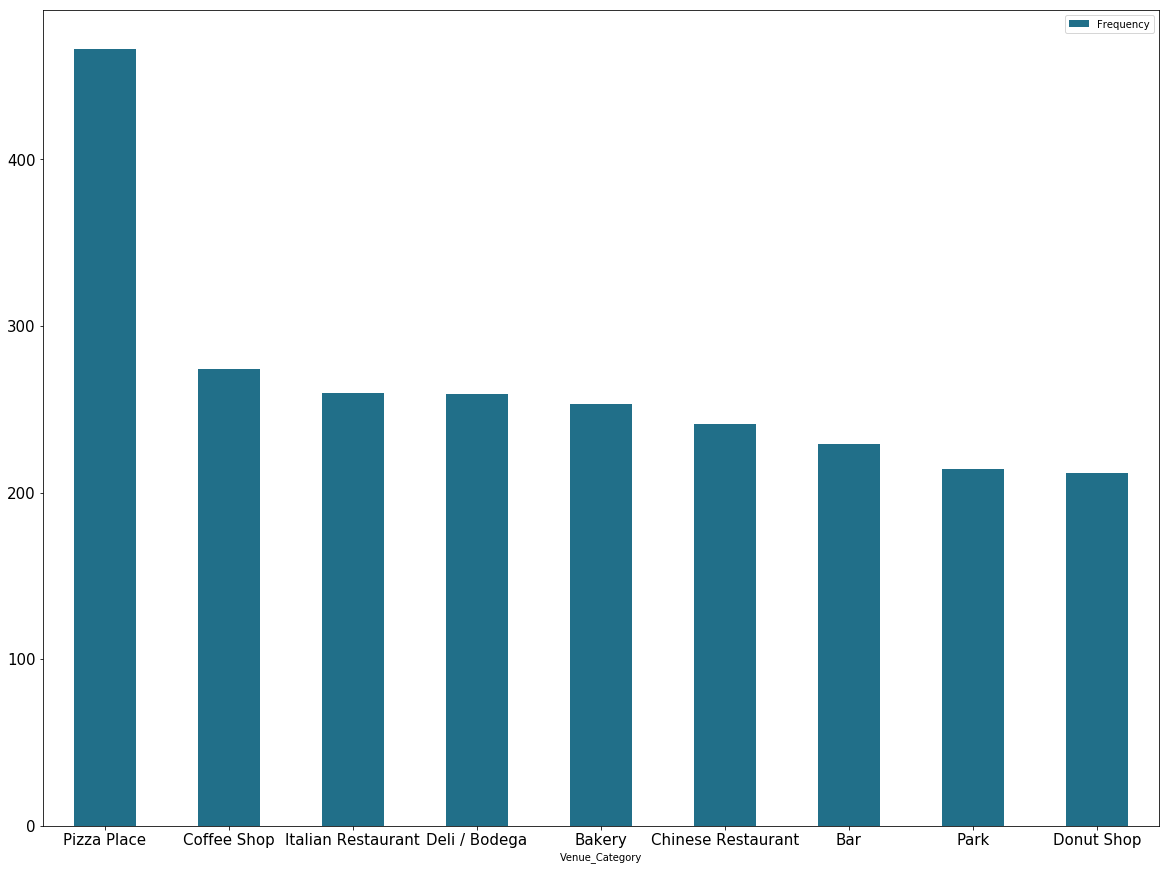

In [18]:
df_top10=df_top10=pd.DataFrame(venues['Venue Category'].value_counts()).reset_index(drop=False)[0:9]
df_top10.columns=["Venue_Category", "Frequency"]
x=df_top10.plot.bar(x="Venue_Category", y="Frequency", rot=0, figsize=(20,15), stacked=False, color="#216F89", fontsize=15)

# Entrenando al modelo
En esta sección los pasos para terminar de preparar los datos y el modelado son presentados. Cabe resaltar que se cuenta hasta esta celda con dos dataframes. El primero de ellos, es llamado df_4square y contiene la información relativa al código postal. 

In [19]:
v=venues[venues.duplicated(["PostalCode"], keep="first")==False]
v.reset_index(inplace=True, drop=True)
ny_collisions=pd.merge(df_4square, v[["PostalCode", "#_Venues"]], on="PostalCode", how="inner" )
ny_collisions.sample(n=10)

,PostalCode,Borough,Latitude,Longitude,Collisions,Radius,#_Venues
84,10014,MANHATTAN,40.736614,-74.009447,107,549.0,200
160,11423,QUEENS,40.717007,-73.768378,106,995.0,59
30,11201,BROOKLYN,40.698677,-73.985941,400,824.0,168
25,11207,BROOKLYN,40.665510,-73.891890,620,995.0,69
134,11372,QUEENS,40.752792,-73.880130,248,617.0,105
111,10278,MANHATTAN,40.715135,-74.003938,3,156.0,5
29,11203,BROOKLYN,40.651588,-73.933043,410,903.0,40
96,10030,MANHATTAN,40.817341,-73.943330,46,308.0,26
19,10473,BRONX,40.811547,-73.859549,161,1054.0,22
142,11412,QUEENS,40.696398,-73.762495,181,1009.0,35


<IPython.core.display.Javascript object>


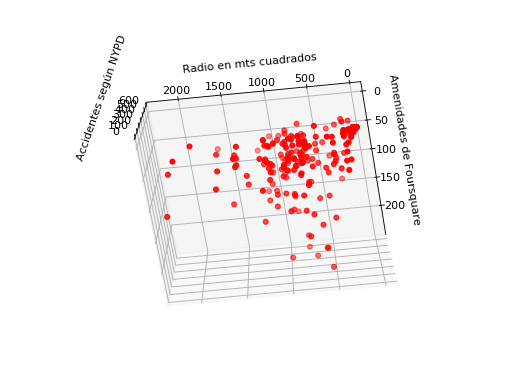

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x =ny_collisions["#_Venues"]
y =ny_collisions["Radius"]
z =ny_collisions["Collisions"]

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Amenidades de Foursquare')
ax.set_ylabel('Radio en mts cuadrados')
ax.set_zlabel('Accidentes según NYPD')

plt.show()

In [21]:
from sklearn.linear_model import LinearRegression
from string import ascii_letters
from sklearn import preprocessing
Y=ny_collisions[["Collisions"]]
X=ny_collisions[["Radius","#_Venues"]]
reg = LinearRegression().fit(X, Y)
reg.score( X, Y, sample_weight=None)

0.093310864359899

Hemos terminado el entrenamiento del modelo, por lo que podemos proceder con la predicción de la densidad de accidentes viales en la ciudad de Guadalajara.

## Predicciones de accidentes en GDL
En esta sección la predicción de accidentes utilizando como variables predictoras al radio y amenidades de foursquare para cada PostalCode es presentado.


1) Inicialmente se presenta el trabajo para recuperar el dataset de códigos postales de Guadalajara.

2) Después se realizan las predicciones.

3) Presentar los resultados en un mapa de calor.

In [22]:
# The code was removed by Watson Studio for sharing.

In [23]:
import boto3
import io
filename="Jalisco.xlsx"
resource = boto3.resource(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url = endpoint,
)
obj = resource.Object(bucket_name=bucket_name, key=filename).get()
obj_bytes = obj['Body'].read() # .read() returns a byte string
obj_bytes_stream = io.BytesIO(obj_bytes) # that we convert to a stream
gdl_df=pd.read_excel(obj_bytes_stream, sheetname="Jalisco")[["d_asenta","d_codigo", "D_mnpio"]] # and eventually a pandas data

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/util/_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


In [24]:
gdl_df.columns=["Neighborhood","PostalCode", "Borough"]
gdl_df=gdl_df.loc[gdl_df['Borough'].isin(['Guadalajara'])]
totalPost=gdl_df["PostalCode"].unique().shape[0]
index=gdl_df.index.values.astype(int)
gdl_df=gdl_df.groupby(["PostalCode", "Borough"])["Neighborhood"].apply(lambda x:"%s" % ", ".join(x)).to_frame()
gdl_df.reset_index(level=1, inplace=True)
gdl_df.reset_index(level=0, inplace=True)
import googlemaps
directions=gdl_df["PostalCode"].astype('<U21')+", Jalisco, Mexico"
gmaps = googlemaps.Client(key=my_key)
i=len(directions)
lat=np.zeros(i)
long=np.zeros(i)
for j in range(i):
    direction=directions[j]
    geocode_result = gmaps.geocode(direction)
    lat[j]=geocode_result[0]["geometry"]["location"]["lat"]
    long[j]=geocode_result[0]["geometry"]["location"]["lng"]
gdl_df["Latitude"]=lat
gdl_df["Longitude"]=long
locations_gdl=gdl_df[["Latitude", "Longitude"]]
gdl_df=gdl_df[["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]]
df_4square=get_radius(gdl_df, locations_gdl)

In [25]:
gdl_df.sample(n=12)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius
129,44790,Guadalajara,"Agustín Yáñez, Jardines de San Francisco, La F...",20.665741,-103.290880,397.0
101,44689,Guadalajara,Terranova,20.682204,-103.388334,151.0
158,44930,Guadalajara,Colón Industrial,20.641220,-103.371003,422.0
154,44918,Guadalajara,Mariano Matamoros,20.659538,-103.349438,0.0
161,44949,Guadalajara,Zona Industrial 2a. Sección,20.659538,-103.349438,0.0
100,44680,Guadalajara,"Residencial Juan Manuel, Circunvalación Vallar...",20.682431,-103.385445,151.0
147,44895,Guadalajara,El Mirador Álamo,20.630233,-103.324800,404.0
127,44770,Guadalajara,"Benito Juárez, Lagos de Oriente 2a. Sección, H...",20.669562,-103.279335,451.0
166,44966,Guadalajara,Patria Nueva,20.623304,-103.373711,255.0
163,44956,Guadalajara,"Villas del Sur 2, Villas del Sur 1",20.659538,-103.349438,0.0


In [26]:
ID=df_4square["PostalCode"]
latitudes=df_4square['Latitude']
longitudes=df_4square['Longitude']
radius=df_4square["Radius"]
venue_gdl = getNearbyVenues(ID, latitudes, longitudes, radius)

In [27]:
print('En el dataset existen {} códigos postales'.format(df_4square['PostalCode'].shape[0]))
print('Y el total de códigos postales con amenidades en foursquare son:', venue_gdl['PostalCode'].unique().shape[0])
print("Finalmente se recuperaron un total de  {} amenidades distribuidas en {} categorias.".format(venue_gdl.shape[0], venue_gdl["Venue Category"].unique().shape[0]))

En el dataset existen 179 códigos postales
Y el total de códigos postales con amenidades en foursquare son: 121
Finalmente se recuperaron un total de  1531 amenidades distribuidas en 218 categorias.


In [28]:
venue_gdl.sample(n=12)

,PostalCode,Radius,#_Venues,Venue,Venue Latitude,Venue Longitude,Venue Category
1332,44829,380.0,6,Tacos Tia Mony,20.657629,-103.286688,Food Stand
1153,44689,151.0,4,Piaf Reposteria,20.682970,-103.387135,Vegetarian / Vegan Restaurant
631,44400,240.0,4,Tostadas de Pata Marty,20.666227,-103.329834,Restaurant
87,44130,258.0,44,AirePAZ Chocolatería,20.673444,-103.378929,Dessert Shop
378,44260,270.0,13,La Playa,20.695839,-103.354553,Liquor Store
417,44270,422.0,21,MC PILLY,20.699500,-103.342691,Burger Joint
41,44100,419.0,79,Bubble Pop,20.674872,-103.353955,Bubble Tea Shop
1252,44770,451.0,6,Tropicrepas Y Bionicos,20.667939,-103.278092,Food Truck
492,44299,278.0,21,Tacos El Foco Verde,20.700907,-103.334016,Taco Place
1352,44890,281.0,10,LED Eléctrica,20.666118,-103.334215,Hardware Store


In [30]:
venues_gdl=venue_gdl[venue_gdl.duplicated(["PostalCode"], keep="first")==False]
venues_gdl.reset_index(inplace=True)
gdl_x=venues_gdl[["PostalCode", "Radius", "#_Venues"]]

In [51]:
gdl_x.sample(n=10)

,PostalCode,Radius,#_Venues
24,44299,278.0,21
2,44130,258.0,44
63,44630,346.0,32
71,44689,151.0,4
117,44980,268.0,1
48,44470,325.0,6
5,44160,238.0,18
44,44450,177.0,5
21,44280,636.0,35
1,44110,184.0,7


In [39]:
X_GDL=gdl_x[["Radius","#_Venues"]]
temporal=venues_gdl[["PostalCode", "Radius", "#_Venues"]]
temporal["Collisions"]=reg.predict(X_GDL)
gdl_results=pd.merge(gdl_df[["PostalCode", "Borough","Neighborhood", "Latitude", "Longitude"]], temporal, on="PostalCode", how="inner")

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [40]:
gdl_results.sample(n=10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Radius,#_Venues,Collisions
71,44689,Guadalajara,Terranova,20.682204,-103.388334,151.0,4,99.585103
8,44190,Guadalajara,Moderna,20.663242,-103.360173,388.0,22,119.561351
90,44790,Guadalajara,"Agustín Yáñez, Jardines de San Francisco, La F...",20.665741,-103.290880,397.0,5,108.776151
37,44399,Guadalajara,"Altavista de Guadalajara, Villas de La Barranc...",20.727312,-103.287994,806.0,4,122.319059
100,44890,Guadalajara,"Jardines Del Rosario, Rancho Blanco Álamo, Ref...",20.667526,-103.333462,281.0,10,108.013977
12,44220,Guadalajara,"Santa Mónica, Guadalupana Norte, Santa Elena A...",20.709305,-103.350065,385.0,27,122.721219
97,44840,Guadalajara,"Lomas Del Paradero, Sutaj, Universitaria, Ciud...",20.649108,-103.316860,317.0,4,105.346686
47,44469,Guadalajara,Barragán y Hernández,20.665274,-103.343568,177.0,4,100.487520
88,44770,Guadalajara,"Benito Juárez, Lagos de Oriente 2a. Sección, H...",20.669562,-103.279335,451.0,6,111.303199
25,44300,Guadalajara,"Esperanza, Jardines de Santa Isabel, San Migue...",20.712473,-103.309643,419.0,5,109.539734


In [43]:
def generateBaseMap(default_adress, default_zoom_start=12):
    address = default_adress
    geolocator = Nominatim(user_agent="ny_explorer")
    location_gdl = geolocator.geocode(address)
    latitude = location_gdl.latitude
    longitude = location_gdl.longitude
    base_map = folium.Map(location=[latitude, longitude], control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [50]:
from folium.plugins import HeatMap
address="Guadalajara, Mexico"
base_map = generateBaseMap(default_adress=address)
HeatMap(data=gdl_results[['Latitude', 'Longitude', 'Collisions']].values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map